In [196]:
# Initialize Otter
import otter
grader = otter.Notebook("cs178_sp25_hw2.ipynb")

<div align="center">
<h1> CS178: Machine Learning & Data Mining </h1>
<h2> Homework 2: Due Friday 25 April 2025 (11:59 PM) </h2>
<h3> Version 1.0 (Last Modified: 11 April 2025) </h3>

---
## Instructions

This homework (and many subsequent ones) will involve data analysis and reporting on methods and results using Python code. You will submit **hw2.ipynb** that contains everything to Gradescope. Please do not rename the notebook. This includes any text you wish to include to describe your results, the complete code snippets of how you attempted each problem, and any figures that were generated (make sure to run all cells before submitting). It is important that you include enough detail that we know how you solved the problem, since otherwise we will be unable to grade it.

Your homework will be given to you as a zipfile containing the data and a Jupyter notebook with problem descriptions and some template code that will help you get started. You **must** use this starter Jupyter notebook to complete your assignment.

If you have any questions/concerns about using Jupyter notebooks, ask us on EdD.

### Summary of Assignment: 100 total points
- Problem 1: Gradient Descent (40 points)
    - Problem 1.1: Visualize decision boundary of linear classifier (5 points)
    - Problem 1.2: Implement a function to compute mean squared error (MSE) (5 points)
    - Problem 1.3: Write out the gradient of MSE. They then implement a function that computes this gradient (10 points)
    - Problem 1.4: Have the students implement gradient descent with the gradient they compute above. Have them create a plot of loss vs training iteration, to see it converges (10 points)
    - Problem 1.5: Plot the trajectory of gradient descent for a few steps. Describe in words what they see happening (10 points)

- Problem 2: Logistic Regression (55 points)
    - Problem 2.1: Test logistic regression model implemented in sklearn (15 points)
    - Problem 2.2: Explore Amazon Review dataset (10 points)
    - Problem 2.3: Fit a logistic regression classifier on Amazon Review dataset. (10 points)
    - Problem 2.4: Find the top k most negative/most positive features and corresponding coefficients. (10 points)
    - Problem 2.5: Tune regularization parameter on Amazon Review dataset (10 points)
- Statement of Collaboration (5 points)

Before we get started, let's import some libraries that you will make use of in this assignment. Make sure that you run the code cell below in order to import these libraries.

**Important: In the code block below, we set `seed=1234`. This is to ensure your code has reproducible results and is important for grading. Do not change this.**

**Important: Do not change any codes we give you below, except for those waiting for you to complete. This is to ensure your code has reproducible results and is important for grading. Please do not delete/edit any otter grader cells or html tags identifying questions, otherwise you will not receive credit from the Gradescope autograder.**

In [197]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

---
## Problem 1: Gradient Descent

In this problem, you will implement gradient descent to train a linear model without a bias unit on a 2D Dataset by using the mean square error as loss function. **This linear model can be written as $f_\theta(\textbf{x}) = \theta^T \textbf{x} = \theta_1 x_1 + \theta_2 x_2$, with zero bias (i.e., $\theta_0=0$). In this problem, $\theta_0$ is ommited for simplicity and only $\theta_1$ and $\theta_2$ are optimized via gradient descent.**

Let's first load in the dataset by running the code cell below:

In [198]:
# Load in the seeds dataset
seeds_file = "data/Seed_Data.csv"
seeds_df = pd.read_csv(seeds_file)
seeds_df.head()

,A,P,C,LK,WK,A_Coef,LKG,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [199]:
# Retrieve the unique values of target variable
target_values = seeds_df['target'].unique()
target_values

array([0, 1, 2], dtype=int64)

The dataset is comprised of measurements of geometrical properties of kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian represented by 70 elements each, with attributes derived from high quality visualizations of the internal kernel structure which was detected using a soft X-ray technique from the Institute of Agrophysics of the Polish Academy of Sciences in Lublin. While the dataset includes 3 kernel varieties we will only look at two: Kama and Rosa.

In [200]:
# Replace 'current_column_name' with the actual current column names in your DataFrame
# to make the feature names more descriptive.
seeds_df = seeds_df.rename(columns={
    'A': 'area_A',
    'P': 'perimeter_P',
    'C': 'compactness_C',
    'LK': 'length_of_kernel',
    'WK': 'width_of_kernel',
    'A_Coef': 'asymmetry_coefficient',
    'LKG': 'length_of_kernel_groove'
})

seeds_df.head()

,area_A,perimeter_P,compactness_C,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


In [201]:
# Let's look at 2 classes of target = 0 corresponding to Kama wheat and target = 1 
# corresponding to Rosa wheat.
seeds_subset = seeds_df[(seeds_df['target'] == 0) | (seeds_df['target'] == 1)]
seeds_subset

,area_A,perimeter_P,compactness_C,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0
...,...,...,...,...,...,...,...,...
135,15.38,14.66,0.8990,5.477,3.465,3.600,5.439,1
136,17.36,15.76,0.8785,6.145,3.574,3.526,5.971,1
137,15.57,15.15,0.8527,5.920,3.231,2.640,5.879,1
138,15.60,15.11,0.8580,5.832,3.286,2.725,5.752,1


In [202]:
# For our intuition, we will look at two features of the dataset across
# the two targets we are interested in predicting.
seeds_X = seeds_subset[['area_A', 'asymmetry_coefficient']]
#seeds_X= seeds_subset[['A','A_Coef']]
seeds_y = seeds_subset['target']
X_1 = StandardScaler().fit_transform(seeds_X)     # scale the feature values (usually good to do this)
y_1 = seeds_y

In [203]:
def plot_data(X, y):
    # Make a figure with 1 subplot
    fig, axes = plt.subplots()

    # Scatter plot of features in X
    feature_1 = X[:, 0]  # First column is the first feature (area_A)
    feature_2 = X[:, 1]  # Second column is the second feature (asymmetry_coefficient)

    axes.scatter(feature_1, feature_2, c=y)

    axes.set_xlabel('area_A', fontsize=14)
    axes.set_ylabel('asymmetry_coefficient', fontsize=14)
    axes.set_title('Seed Area vs Asymmetry', fontsize=18)
    
    axes.set_xlim(-3,3)
    axes.set_ylim(-3,3)
    
    return fig, axes

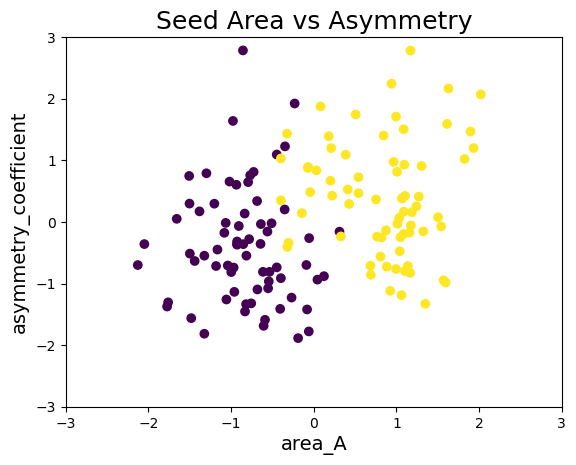

In [204]:
# Run the code below to illustrate the distribution of data points.
fig, axes = plot_data(X_1, y_1)

For this problem, we will focus on the properties of the gradient descent algorithm, rather than classification
performance. Thus we will not create a separate validation dataset, and simply use all available data for training.

<!-- BEGIN QUESTION -->

### Problem 1.1 (5 points): Visualize decision boundary of linear classifier

In our code, the variable `X_1` is a numpy array containing the feature vectors in this 2D dataset, and `y_1` is a numpy array containing the corresponding labels, which are either -1 or 1.

We have a linear model $f_\theta(\textbf{x}) = \theta^T \textbf{x} = \theta_1 x_1 + \theta_2 x_2$, with zero bias (i.e., $\theta_0=0$), where $\textbf{x}$ is an feature vector and $\textbf{x}_j$ refers to the value of the j-th component of the vector $\textbf{x}$. 

- Create a function that, given feature vectors `X`, labels `y` and parameters `theta_1`, `theta_2`, plots the feature vectors colored as their classes and the decision boundary corresponding to this linear classifier. 

Keep in mind that the points **do not** affect the linear classifier yet, we are only plotting the line in order to visualize it alongside the points. (Hint: The decision boundary is given by $\theta_1 x_1 + \theta_2 x_2 = 0$, consider `axes.plot` to draw this function)

In [205]:
def plot_boundary(X, y, theta_1, theta_2): 
    '''
    X:       [# feature vectors, # features], feature vectors
    y:       [# feature vectors], labels
    theta_1: the first parameter of linear model
    theta_2: the second parameter of linear model
    '''
    
    fig, axes = plot_data(X, y)
    
    ### YOUR CODE STARTS HERE ###
    #since the range of the first feature of X, i.e. x1, is [-3, 3] (see the above plot), so we use x1b to denote the x-axis
    # Generate x values for the decision boundary line
    x1_values = np.linspace(-3, 3, 100)
    # Calculate corresponding x2 values: theta1*x1 + theta2*x2 = 0 => x2 = -theta1/theta2 * x1
    x2_values = (-theta_1 / theta_2) * x1_values
    
    # Plot the decision boundary line
    axes.plot(x1_values, x2_values, 'k-', label='Decision Boundary')
    axes.legend()
    
    return fig, axes
    ###  YOUR CODE ENDS HERE  ###

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Seed Area vs Asymmetry'}, xlabel='area_A', ylabel='asymmetry_coefficient'>)

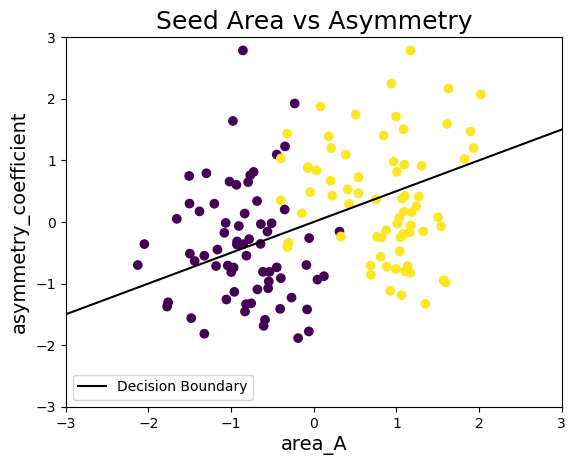

In [206]:
# Display the decision boundary of the linear model governed by the parameters below.
theta_1_random, theta_2_random = -0.5, 1

plot_boundary(X_1, y_1, theta_1_random, theta_2_random)

<!-- END QUESTION -->

### Problem 1.2 (5 points): Loss function

In this problem, we apply the mean squared error (MSE), **which is 1/n of the squared error**, as the loss function for gradient decent. MSE is basically the same as the loss function in Lecture 5 other than the scale of the loss function.

- Implement the function `MSE`.
- Report MSE of the linear model defined by `theta_1_random` and `theta_2_random`, across the dataset ($\textbf{X}$, $\textbf{y}$);
- Visualize the countour plot of MSE in $\theta$ space, from $\theta_1 \in [-2,2]$ and $\theta_2 \in [-2,2]$. (Hint: use `np.meshgrid` to create a grid of possible $(\theta_1, \theta_2)$ values. Use `ax.contour` to plot the values of $J$ in every value in the grid.)

MSE is defined as 
$$
J=\frac{1}{n} \sum_{i=1}^n(f(\textbf{x}_{i})-y_i; \boldsymbol{\theta})^2=\frac{1}{n} \sum_{i=1}^n(\theta_1 x_{i1} + \theta_2 x_{i2}-y_i)^2
$$
- $n$ is the number of training data
- $\textbf{x}_i$ is the feature vector for row $i$ in a data matrix $\textbf{X}$, where $i = 1, ..., n$ is an index over the rows and where $x_{ij}$ refers to the value of the j-th component of the vector $\textbf{x}_i$, where $j = 1, 2$ is an index over features.
- $y_i$ is the class label of the feature vector $\textbf{x}_i$.
- $\theta_1$ and $\theta_2$ are the parameters of the linear model $f$

In [207]:
def predict(x_1, x_2, theta_1, theta_2):
    return theta_1 * x_1 + theta_2 * x_2

def MSE(X, y, theta_1, theta_2): 
    '''
    X:       [# data points, # features], feature vectors
    y:       [# data points], labels
    theta_1: the first parameter of linear model
    theta_2: the second parameter of linear model
    '''
    
    ### YOUR CODE STARTS HERE ###
    # get the first and second features
     # Get the first and second features
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    # Compute predictions
    predictions = predict(x1, x2, theta_1, theta_2)
    
    # Compute squared errors
    squared_errors = (predictions - y) ** 2
    
    # Compute mean squared error
    mse = np.mean(squared_errors)
    
    ###  YOUR CODE ENDS HERE  ###
    return mse

The code below visualizes the countour plot of MSE in $\theta$ space, from $\theta_1 \in [-2,2]$ and $\theta_2 \in [-2,2]$. It uses `np.meshgrid` to create a grid of possible $(\theta_1, \theta_2)$ values. Use `ax.contour` to plot the values of $J$ in every value in the grid.)

In [208]:
def plot_MSE_contour(X, y):
    fig, axes = plt.subplots()

    Theta_1, Theta_2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    
    bs_map = []
    for theta_1, theta_2 in zip(Theta_1.ravel(), Theta_2.ravel()):
        bs_map.append(MSE(X, y, theta_1, theta_2))
        
    bs_map = np.asarray(bs_map).reshape(100, 100)
    
    axes.set_xlabel('theta_1', fontsize=14)
    axes.set_ylabel('theta_2', fontsize=14)
    axes.set_title('MSE', fontsize=18)

    im = axes.contour(Theta_1, Theta_2, bs_map, 100)
    fig.colorbar(im, ax=axes)
    
    return fig, axes

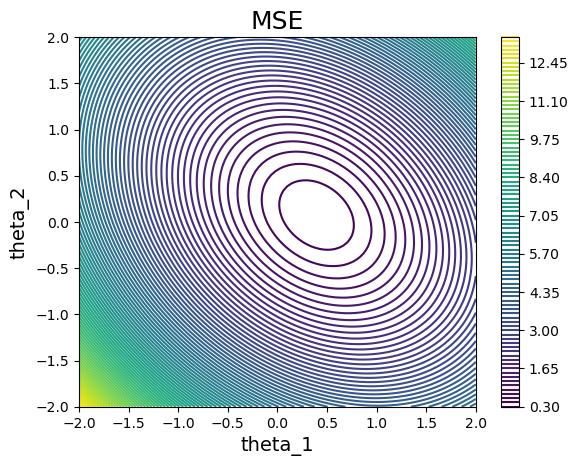

In [209]:
fig, axes = plot_MSE_contour(X_1, y_1)

### Problem 1.3 (10 points): Compute the gradient of MSE

- Note the gradient of MSE with respect to $\theta_1$ and $\theta_2$, i.e., $\frac{\partial}{\partial \theta_1} L(\theta_1, \theta_2)$ and $\frac{\partial}{\partial \theta_2} L(\theta_1, \theta_2)$.

The gradient of MSE is:

$$
\frac{\partial}{\partial \theta_1} L(\theta_1, \theta_2) = \frac{2}{n} \sum_{i=1}^n[(\theta_1 x_{i1} + \theta_2 x_{i2}-y_i)\cdot x_{i1}]
$$

$$
\frac{\partial}{\partial \theta_2} L(\theta_1, \theta_2) = \frac{2}{n} \sum_{i=1}^n[(\theta_1 x_{i1} + \theta_2 x_{i2}-y_i)\cdot x_{i2}]
$$

- Using the equations above, implement the function `gradient_mse` that computes the gradient of MSE. This function should output a tuple, where the first value is the partial derivative with respect to $\theta_1$, and the second values is the partial derivative with respect to $\theta_2$. The two together make up the gradient vector (for this problem).

In [210]:
def gradient_mse(X, y, theta_1, theta_2):
    '''
    X:       [# data points, # features], feature vectors
    y:       [# data points], labels
    theta_1: the first parameter of linear model
    theta_2: the second parameter of linear model
    '''
    ### YOUR CODE STARTS HERE ###
        # Number of data points
    n = len(y)
    
    # Extract features
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    # Compute predictions
    predictions = theta_1 * x1 + theta_2 * x2
    
    # Compute errors
    errors = predictions - y
    
    # Compute partial derivatives
    grad_1 = (2 / n) * np.sum(errors * x1)
    grad_2 = (2 / n) * np.sum(errors * x2)
    ###  YOUR CODE ENDS HERE  ###
    
    return grad_1, grad_2

In [211]:
grad_1, grad_2 = gradient_mse(X_1, y_1, theta_1_random, theta_2_random)
print(f' gradient w.r.t theta_1_random: {grad_1}\n gradient w.r.t theta_2_random: {grad_2}')

 gradient w.r.t theta_1_random: -1.236041389780333
 gradient w.r.t theta_2_random: 1.3154093269419453


**Sample output of** `gradient_mse(X_1, y_1, 1, 0.5)`:
$$ \left.\frac{\partial}{\partial \theta_{1}} L\left(\theta_{1}, \theta_{2}\right)\right|_{\theta_{1}=1, \theta_{2}=0.5} = 1.4649435710370162 $$

$$ \left.\frac{\partial}{\partial \theta_{2}} L\left(\theta_{1}, \theta_{2}\right)\right|_{\theta_{1}=1, \theta_{2}=0.5} = 1.2124544444898946 $$

### Problem 1.4 (10 points): Gradient descent algorithm

- Implement the function `gradient_descent`, this function should output a list of `theta_1s`, `theta_2s`, and `mses` containing the value of each of each variable at each step.
- Create a plot of MSE vs training iteration, to see if it converges. (hint: use the `mses` list from the last point).

In [212]:
def gradient_descent(X, y, theta_1_init, theta_2_init, lr=0.001, max_iters=100, display_boundary=False):
    # use theta_1s and theta_2s to denote the set of updates about theta_1 and theta_2
    theta_1s = [theta_1_init]
    theta_2s = [theta_2_init]
    mses = [MSE(X, y, theta_1_init, theta_2_init)]
    
    # initialize theta_1 and theta_2 to theta_1_init and theta_2_init
    theta_1, theta_2 = theta_1_init, theta_2_init
    
    # gradient descent iterations
    for iter in range(max_iters):
        ### YOUR CODE STARTS HERE ###

        # compute the gradient of MSE w.r.t to theta_1 and theta_2 (i.e., grad_1 and grad_2)
        grad_1, grad_2 = gradient_mse(X,y,theta_1,theta_2)
        
        # update theta_1 and theta_2 based on the gradients and learning rate (lr)
        theta_1 = theta_1 - lr * grad_1
        theta_2 = theta_2 - lr * grad_2
        # compute the MSE based on the updated parameters theta_1 and theta_2
        mse = MSE(X,y,theta_1,theta_2)
        
        ###  YOUR CODE ENDS HERE  ###
        
        theta_1s.append(theta_1) # add new updates about theta_1 to theta_1s
        theta_2s.append(theta_2) # add new updates about theta_2 to theta_2s
        
        mses.append(mse)
        
        # show the decision boundary every 20 iterations
        if iter % 20 == 0 and display_boundary:
            plot_boundary(X, y, theta_1, theta_2)

    return theta_1s, theta_2s, mses

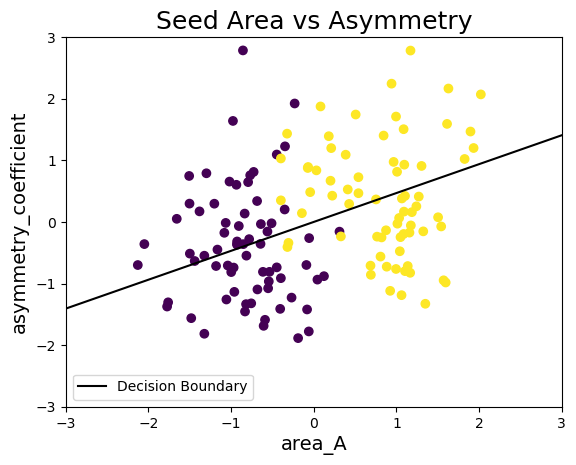

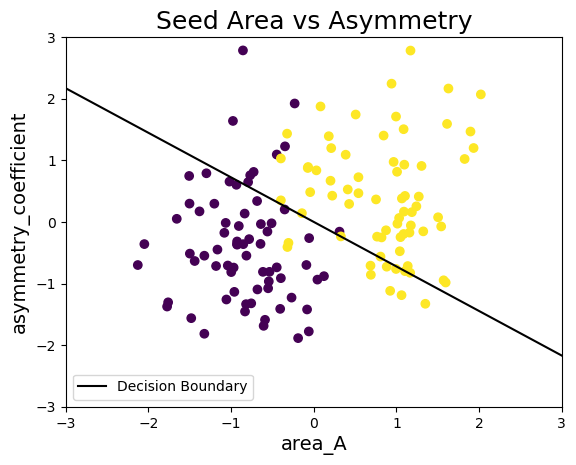

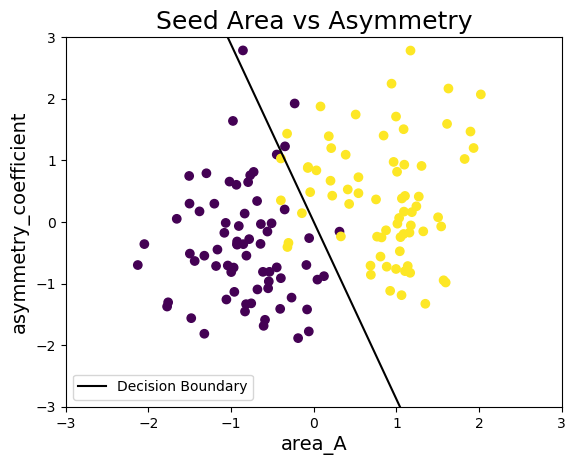

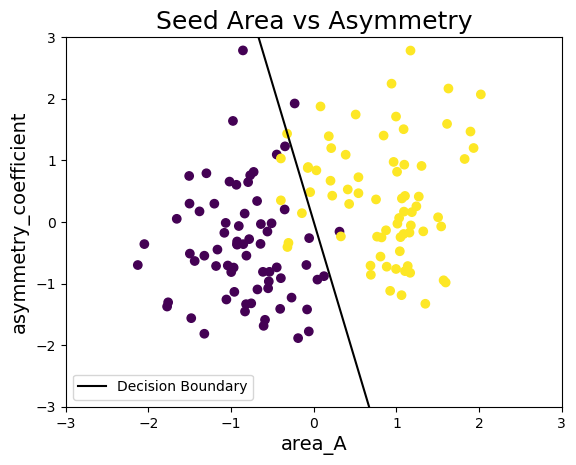

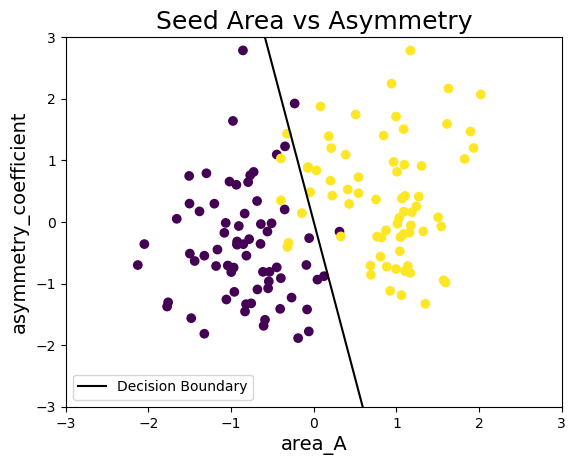

In [213]:
# Run the code below to fit a model using MSE. Don't change the function argument values we provide: 
# (i.e., the learning rate is 0.05, maximum iteration is 100 and display boundary during gradient descent).
theta_1s, theta_2s, mses = gradient_descent(X_1, y_1, theta_1_random, theta_2_random, 
                                            lr=0.05, max_iters=100, display_boundary=True)

- Create a plot of MSE vs training iteration to check that it converges. You can run the code given below to do this.

Text(0, 0.5, 'MSE')

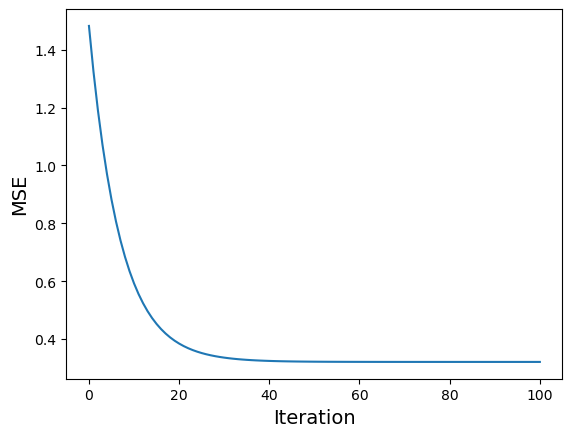

In [214]:
# Create a plot of MSE vs training iteration
fig, axes = plt.subplots()
axes.plot(mses)
axes.set_xlabel('Iteration', fontsize=14)
axes.set_ylabel('MSE', fontsize=14)

**If your implementation of `gradient_descent` is correct, the curve should converge.**

<!-- BEGIN QUESTION -->

### Problem 1.5 (10 points): Plot the trajectory of gradient descent 

- Using `axes.arrow`, show the position of $\theta$ at every step, and the corresponding gradient vectors. 
- Describe in words what you observe from the trajectory.

In [215]:
# Run this cell and it will display the trajectory of gradient descent
# In this problem, the initialization of (theta_1, theta_2) is (2,2). Please don't change any parameter below.
theta_1s_demo, theta_2s_demo, _ = gradient_descent(X_1, y_1, 2, 2, lr=0.3, max_iters=10, display_boundary=False)

In [216]:
def gradient_decent_trajectory(X, y, theta_1s, theta_2s):
    fig, axes = plot_MSE_contour(X, y)

    theta_1s = np.asarray(theta_1s)
    theta_2s = np.asarray(theta_2s)
    
    ### YOUR CODE STARTS HERE ###

    # use 'axes.arrow' (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.arrow.html)
    # to generate one vector with arrow on the fig
    # you should call 'axes.arrow' iteratively to generate the whole gradient decent trajectory step by step.
    # your job is to identify the 'x, y, dx, dy' for axes.arrow, based on 'theta_1s' and  'theta_2s'
    # suggestions of other parameters for 'axes.arrow': head_width = 0.1, color = 'red'

     # Plot the trajectory with arrows
    for i in range(len(theta_1s) - 1):
        x = theta_1s[i]
        y_val = theta_2s[i]
        dx = theta_1s[i+1] - theta_1s[i]
        dy = theta_2s[i+1] - theta_2s[i]
        axes.arrow(x, y_val, dx, dy, head_width=0.05, head_length=0.1, fc='red', ec='red')
    ###  YOUR CODE ENDS HERE  ###
    axes.set_xlim(-1,1.5)
    axes.set_ylim(-1,1)

    axes.set_title('Gradient Descent Trajectory', fontsize=18)
    return fig, axes

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->



(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Gradient Descent Trajectory'}, xlabel='theta_1', ylabel='theta_2'>)

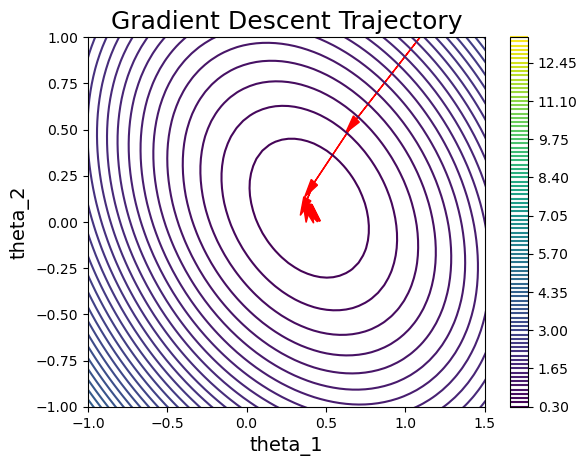

In [217]:
gradient_decent_trajectory(X_1, y_1, theta_1s_demo, theta_2s_demo)

- Describe in words what you observe from the trajectory and explain it.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

---
## Problem 2: Logistic Regression

<font color='red'><b>Important: We will need to install two more libraries for this assignment, do not skip this.</b></font>

We need to run `conda install -c conda-forge simplejson nltk` in order to install `nltk` and `simplejson`. 

We need `nltk` to work with natural language data.

In this problem, you will work with the sklearn implementation of logistic regression on toy data and a more realistic dataset.

In [218]:
#import simplejson as json
import nltk 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arshi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\arshi\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# Problem 2.1 (15 points): Classify Seeds dataset via scikit-learn implementations of logistic regression

Using sklearn's `LogisticRegression` class, train a model (`classifier`) that fits the seeds dataset we have been using from the previous question. Make sure to use the parameters `penalty='none', fit_intercept=False` when instantiating the class. You can view the documentation for this class [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

- Print out the $\theta_1$ and $\theta_2$. (Hint: You can get the values of `theta_1_a` and `theta_2_a` from `classifier.coef_`)
- Plot the boundaries and the data.

5.496267607009478 1.4045172513166815


c:\Users\arshi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Seed Area vs Asymmetry'}, xlabel='area_A', ylabel='asymmetry_coefficient'>)

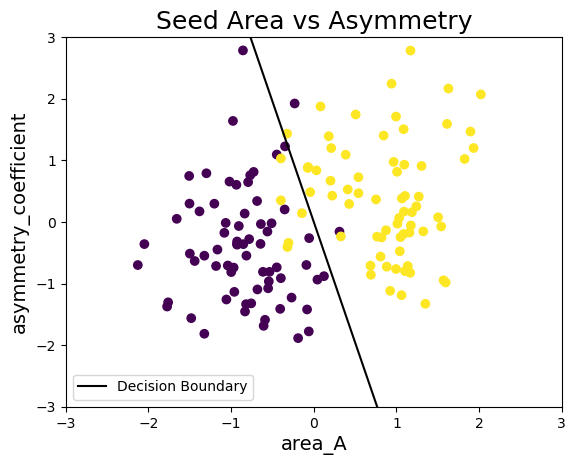

In [219]:
### YOUR CODE STARTS HERE ###
# Set up the classifier.
clf_a = LogisticRegression(penalty=None, fit_intercept=False, solver='lbfgs', multi_class='ovr')


# Train the classifier
clf_a.fit(X_1, y_1)

# Get classifier parameters (clf.coef_ is a 2D array with shape (n_classes, n_features))
#theta_1_a, theta_2_a = clf_a.coef_[:, 0], clf_a.coef_[:, 1]
theta_1_a, theta_2_a = clf_a.coef_[0]
###  YOUR CODE ENDS HERE  ###

print(theta_1_a, theta_2_a)
plot_boundary(X_1, y_1, theta_1_a, theta_2_a)

Using sklearn's `LogisticRegression` class, train a model that fits the seeds dataset we have been using from the previous question. Use the parameters `penalty='none', fit_intercept=True` when instantiating the class.

- Print out the `theta_0_b`, `theta_1_b` and `theta_2_b`. (Hint: You can get the values of `theta_0_b` from `clf.intercept_`)
- You should find $\theta_0$ is not zero.

In [220]:
### YOUR CODE STARTS HERE ###

# set up the classifier
clf_b = LogisticRegression(penalty=None, fit_intercept=True, solver='lbfgs', multi_class='ovr')

# Fit the classifier
clf_b.fit(X_1, y_1)

# get classifier parameters
theta_0_b = clf_b.intercept_
theta_1_b, theta_2_b = clf_b.coef_[:, 0], clf_b.coef_[:, 1]

### YOUR CODE ENDS HERE ###

print(theta_0_b, theta_1_b, theta_2_b)

[0.43779515] [5.80423825] [1.33123111]


c:\Users\arshi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


<!-- BEGIN QUESTION -->

- Implement function `plot_boundary_w_intercept`. Think about how to modify `plot_boundary` to make it compatible with the linear model with bias (i.e., $\theta_0$ is not necessarily zero).

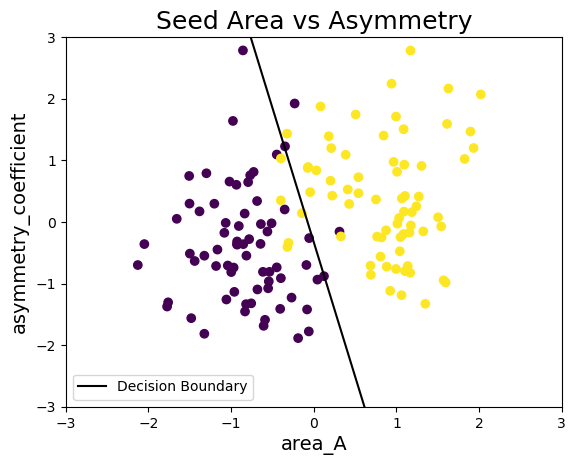

In [221]:
def plot_boundary_w_intercept(X, y, theta_0, theta_1, theta_2): 
    '''
    X:       [# feature vectors, # features], feature vectors
    y:       [# feature vectors], labels
    theta_0: the bias of linear model
    theta_1: the first parameter of linear model
    theta_2: the second parameter of linear model
    '''
    
    # the code is similar with that in Problem 1, but we have new theta_1 and theta_2 which are the coefficients for the well trained model
    fig, axes = plot_data(X, y)
    ### YOUR CODE STARTS HERE ##
    x1_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)

    # Support both binary and multiclass (One-vs-Rest)
    if theta_0.ndim == 0 or len(theta_0) == 1:
        x2_vals = -(theta_0 + theta_1 * x1_vals) / theta_2
        axes.plot(x1_vals, x2_vals, label="Decision Boundary", color="black")
    else:
        colors = ['r', 'g', 'b']
        for i in range(len(theta_0)):
            x2_vals = -(theta_0[i] + theta_1[i] * x1_vals) / theta_2[i]
            axes.plot(x1_vals, x2_vals, label=f"Class {i} boundary", color=colors[i % len(colors)])

    axes.legend()
    plt.show()
    ### YOUR CODE STARTS HERE ##

# Call your function on the classifier you fit in the previous point
plot_boundary_w_intercept(X_1, y_1, theta_0_b, theta_1_b, theta_2_b)

<!-- END QUESTION -->

### Problem 2.2 (10 points): Explore Amazon Review dataset

The Amazon Reviews dataset consists of reviews with their scores (1 to 5). This review data can be used in a classification task, where we are given a review and we predict whether it is a positive or a negative review. We will consider a review as *negative* if it has a score $\leq 2$, or *positive* if it has a score $\geq 4$.

Below we pre-process the dataset for you using what's known as a bag-of-words approach. You will run the code create a bag of words (BOW) representation from text documents, using the Vectorizer function in scikit-learn to convert each text review (a string) to a fixed-length vector of numbers that we use as a feature vector for a classifier. 

Note that the details of how reviews are converted to vectors is not particularly important for you to follow in detail. What is important is to be aware that after we run the code below we will get a data matrix with n rows (one per review) and d features (where each of the d features corresponds to a different word). Each row in the data matrix is a feature vector for a Amazon review, where the values in the feature vector correspond to how often different words occur in the review.

In a bit more detail, the bag of words representation of text is a way to turn text (in the form of a string) into a vector of some fixed dimension. More specifically, every document (e.g., a review) is converted into a vector $\mathbf{x}$, where $\mathbf{x}_j$ denotes whether the j-th word from the vocabulary list is used in the sentence. For example, if our vocabulary is `[he, she, his, her, loves, likes, dogs, cats, cute, nice]`, the sentence `"he loves cats and she loves dogs"` can be vectorized as `[1, 1, 0, 0, 2, 0, 1, 1, 0, 0]`. This representation allows us to compare documents (e.g., reviews) in the same way we have been doing with tabular data and images.

The inputs are 
- a filename (you will use "amazon_reviews.csv") containing the reviews in csv format (provided in your student .zip file)
- the min_pos and max_neg parameters (use the default values.)

The outputs are
- **X**: Feature Matrix in compressed sparse row format.
    - $\textbf{X}$ is in shape of [# reviews, # terms in vocabulary]  (where #terms = #features)
    - $\textbf{X}_{ij}$ indicates the number of the j-th term in the vocabulary existing in the $i$th review.
- **y**: Review label vector
- **text**: Raw reviews
- **vectorizer_BOW.vocabulary_**: A mapping of terms to feature indices, somes terms are excluded



**NOTE**: 
- please read the scikit-learn tutorial on text feature extraction before you start this problem: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction  (it is fine to just read Sections 6.2.3.1 to 6.2.3.3)

In [222]:
def create_bow_from_reviews(filename, min_pos=4, max_neg=2): 
    
    print('Loading the file:', filename) 
    with open(filename, 'r') as file:
        data = pd.read_csv(file)

    data_sub = data[['reviewText', 'overall']]
    data_clean = data_sub.dropna()
        
    print('Total number of reviews extracted =', len(data))

    print('Extracting tokens from each review.....(can be slow for a large number of reviews)......')   
    # do not consider reviews with scores above max_neg and below min_pos (these reviews will be dropped)

    text = data_clean['reviewText'].tolist() # keep only the text and label
    
    # represent scores > min_pos as "1"
    # represent scores < max_neg as "0"
    y = data_clean[['overall']].astype(int)
    y[y >= min_pos] = 1
    y[y <= max_neg] = 0
    
    # create an instance of a CountVectorizer, using 
    # (1) the standard 'english' stopword set 
    # (2) only keeping terms in the vocabulary that occur in at least 1% of documents
    # (3) allowing only unigrams in the vocabulary (use "ngram_range=(1, 1)" to do this)
    vectorizer = CountVectorizer(stop_words='english', min_df=0.02, ngram_range=(1, 1))

    # create a sparse BOW array from 'text' using vectorizer
    X = vectorizer.fit_transform(text)
 
    print('Data shape: ', X.shape)
    
    # you can uncomment this next line if you want to see the full list of tokens in the vocabulary  
    #print('Vocabulary: ', vectorizer.get_feature_names())
 
    return X, y, vectorizer, text

In [223]:
X_2, y_2, vectorizer_BOW, text = create_bow_from_reviews('data/amazon_reviews.csv') 

Loading the file: data/amazon_reviews.csv
Total number of reviews extracted = 4915
Extracting tokens from each review.....(can be slow for a large number of reviews)......
Data shape:  (4914, 189)


<!-- BEGIN QUESTION -->

### Plot a histogram of how many unique words are in each review
- Implement the function `review_word_count_histogram`, which generates a histogram to show how many unique words (from the vocabulary) are in each review. That is, for each review, count the number of unique words in the review, and plot a histogram illustrating these counts.

In [224]:
def review_word_count_histgram(X):
    '''
    X:  [# feature vectors, # features], feature vectors
    '''
    ### YOUR CODE STARTS HERE ###
    unique_word_counts = X.getnnz(axis=1)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(unique_word_counts, bins=30, color='skyblue', edgecolor='black')
    plt.title("Histogram of Unique Words per Review")
    plt.xlabel("Number of Unique Words")
    plt.ylabel("Number of Reviews")
    plt.grid(True)
    plt.show()
    ### YOUR CODE ENDS HERE ###


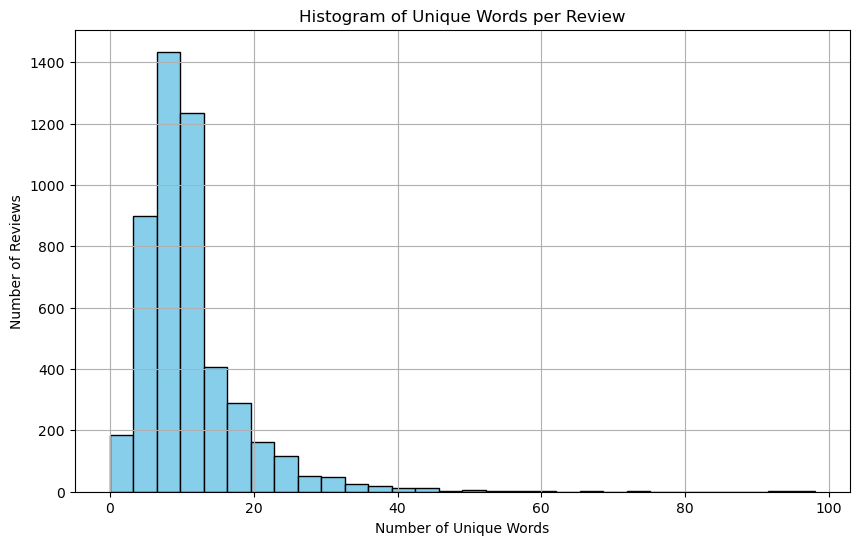

In [225]:
review_word_count_histgram(X_2)

<!-- END QUESTION -->

### Problem 2.3 (10 points): Fit a logistic regression classifier on Amazon Review dataset.

You will now build a logistic regression model to classify reviews as either negative or positive. In the code you are given, a training/testing split has already been created for you.

- Build a logistic classifier on the training subset. **Please use `penalty='l1'`, `solver='liblinear'` and `fit_intercept=True` when calling `LogisticRegression`.**
- Evaluate the accuracy of your model on the test subset.

**NOTE**: 
before starting this problem please read the scikit-learn documentation on [linear classifiers](https://scikit-learn.org/stable/modules/linear_model.html) and [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

In [226]:
def logistic_classification(X, y): 

    # Convert y to 1D array if it’s a DataFrame/Series
    y = y.values.ravel() if hasattr(y, 'values') else y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #  set the state of the random number generator so that we get the same results across runs when testing our code
     
    print('Number of training examples: ', X_train.shape[0])
    print('Number of testing examples: ', X_test.shape[0])   
    print('Vocabulary size: ', X_train.shape[1]) 

    ### YOUR CODE START HERE ### 

    # Specify the logistic classifier model
    # # Please use 'l1' penality type, 'liblinear' solver and enable fit_intercept
    classifier = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)

    # Train a logistic regression classifier and evaluate accuracy on the training data
    print('\nTraining a model with', X_train.shape[0], 'examples.....')
    # Training 
    classifier.fit(X_train, y_train)
    
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print('\nTraining accuracy:',format( 100*train_accuracy , '.2f') ) 

    # Compute and print accuracy on the test data
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)

    ### YOUR CODE ENDS HERE ###
    print('\nTesting accuracy:', format( 100*test_accuracy , '.2f') )

    return classifier, train_accuracy, test_accuracy

In [227]:
logistic_classifier, _, _ = logistic_classification(X_2, y_2)

Number of training examples:  3439
Number of testing examples:  1475
Vocabulary size:  189

Training a model with 3439 examples.....

Training accuracy: 97.41

Testing accuracy: 96.61


### Problem 2.4 (10 points): Find the top k most negative and most positive features

In this problem, you will complete the function `most_significant_terms` to 
- print out and return the most significant positive and negative weights 
- print our the associated terms

`most_significant_terms` takes as input
- a scikit-learn trained logistic regression classifier (e.g., trained in Problem 2.3) 
- a scikit-learn vectorizer object that produced the BOW features for the classifier

and prints out
- the terms in the vocabulary tokens with the **top10** largest positive weights  
- the terms in the vocabulary with the **top10** smallest (i.e., largest in terms of absolute value) negative weights

Hint: Check the attributes section of the vectorizer documentation (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to find where the mapping between words and indices are located.

In [228]:
def most_significant_terms(classifier, vectorizer, K):
    # cycle through the positive weights, in the order of largest weight first and print out
    # K lines where each line contains
    # (a) the term corresponding to the weight (a string)
    # (b) the weight value itself (a scalar printed to 3 decimal places)

    ### YOUR CODE STARTS HERE ###
    # extract coefficients from trained model and sort based on coefficient
    feature_importance = classifier.coef_[0]
    # the index of sorted coefficient
    sorted_idx = np.argsort(feature_importance)
    # extract topK positive terms
    topK_pos_terms = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(w)] for w in
                      sorted_idx[-K:][::-1]]
    # extract corresponding weights
    topK_pos_weights = [round(feature_importance[w], 3) for w in sorted_idx[-K:][::-1]]

    topK_neg_terms = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(w)] for w in
                      sorted_idx[:K]]
    topK_neg_weights = [round(feature_importance[w], 3) for w in sorted_idx[:K]]

    ### YOUR CODE ENDS HERE ###
    print('topK_pos_weights', topK_pos_weights)
    print('topK_pos_terms', topK_pos_terms)
    print('topK_neg_weights', topK_neg_weights)
    print('topK_neg_terms',topK_neg_terms)
    return topK_pos_weights, topK_pos_terms, topK_neg_weights, topK_neg_terms

In [229]:
topK_pos_weights, topK_pos_terms, topK_neg_weights, topK_neg_terms = most_significant_terms(logistic_classifier, vectorizer_BOW, K=10)

topK_pos_weights [1.246, 1.099, 0.989, 0.964, 0.806, 0.77, 0.734, 0.666, 0.601, 0.594]
topK_pos_terms ['better', 'lost', 'performance', 'think', 'day', 'does', 'working', 'having', 's4', 'advertised']
topK_neg_weights [-1.833, -1.177, -1.125, -1.004, -0.988, -0.963, -0.941, -0.896, -0.859, -0.853]
topK_neg_terms ['formatting', 'pictures', 'buying', 'excellent', 'happy', 'purchase', 'quality', 'complaints', 'wanted', 'issues']


<!-- BEGIN QUESTION -->

### Problem 2.5 (10 points): Tune regularization parameter on Amazon Reviews dataset

In this problem, you will tune the regularization parameter of your logistic regression model in order to increase your accuracy.

- Complete the function `accuracy_vs_reg`. This function should perform L1 regularization using the values defined in the array `cs` below. For each value of the regularization parameter in `cs`, you should store the resulting training accuracy in the list `train_accuracies` and the resulting testing accuracy in the list `test_accuracies`.
- Use your implementation to plot the curves of train/test accuracy vs regularization strength, for the Amazon review data we used above. The plotting code necessary to do this is already given to you, and you only need to call the function.

When plotting the accuracy against the regularization strength we notice that sci-kit learn's implementation of logistic regression [linked here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) uses the inverse of regularization strength as a positive float. Smaller values specify stronger regularization which is why we invert the x-axis in the plotting code provided. 

In [230]:
def accuracy_vs_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
   
    # log initialization
    coefs_ = []
    train_accuracies = []
    test_accuracies = []
    cs = [0, 0.1, 1, 10, 50]

    ### YOUR CODE STARTS HERE ###
    for c in cs:
        # Specify the logistic classifier model
        if c == 0:
            classifier = LogisticRegression(penalty=None, fit_intercept=True)
        else:
            # Refer https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
            # to see which argument can adjust the regularization strength,
            # Additionally, please use 'l1' penalty type, 'liblinear' solver and enable fit_intercept
            classifier = LogisticRegression(penalty='l1', C=c, solver='liblinear', fit_intercept=True)

        classifier.fit(X_train, y_train)

        # log model coefficients
        coefs_.append(classifier.coef_[0])

        # Training
        train_predictions = classifier.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        # Testing: compute and print accuracy and AUC on the test data
        test_predictions = classifier.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_accuracies.append(test_accuracy)

    ### YOUR CODE ENDS HERE ###
    fig, axes = plt.subplots()
    axes.xaxis.set_inverted(True)
    axes.semilogx(cs, train_accuracies, color='red', label='training accuracy')
    axes.semilogx(cs, test_accuracies, color='blue', label='testing accuracy')
    
    axes.set_xlabel('regularization strength', fontsize=14)
    axes.set_ylabel('accuracy', fontsize=14)
    
    axes.legend()

    return train_accuracies, test_accuracies, coefs_

c:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\arshi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

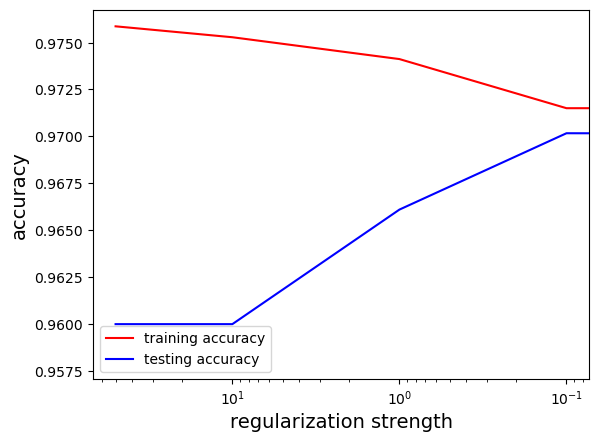

In [231]:
train_accuracies, test_accuracies, coefs = accuracy_vs_reg(X_2, y_2)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---
### Statement of Collaboration (5 points)

It is **mandatory** to include a Statement of Collaboration in each submission, with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed.

All students are required to follow the academic honesty guidelines posted on the course website. For
programming assignments, in particular, I encourage the students to organize (perhaps using EdD) to
discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start
working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not
allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard,
written notes, referring to EdD, etc.). Especially after you have started working on the assignment, try
to restrict the discussion to EdD as much as possible, so that there is no doubt as to the extent of your
collaboration.

A was not able to come to the office hours or discutions for this HW but I have ask some questions about the HW1 grading and why I got a certain grade and I needed to wait for that so that gradescorpe would give some information other than that this was the only question I have asked.

<!-- END QUESTION -->

